In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random

# package(s) related to the simulation
import simpy
import networkx as nx  
import numpy as np
import pandas as pd
import yaml as yaml
import matplotlib.pyplot as plt

# OpenTNSim
from opentnsim import corelock3 as corelock
from opentnsim import plot
from opentnsim import model

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")

In [2]:
Node = type('Site', (corelock.Identifiable, corelock.Log, corelock.Locatable, corelock.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(4.432880, 51.699651)}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(4.428526, 51.699461)}
data_node_3 = {"env": [],
               "name": "Node 3",
               "geometry": shapely.geometry.Point(4.425455, 51.698741)}
data_node_4 = {"env": [],
               "name": "Node 4",
               "geometry": shapely.geometry.Point(4.421810, 51.697049)}
data_node_5 = {"env": [],
               "name": "Node 5",
               "geometry": shapely.geometry.Point(4.418511, 51.695388)}
data_node_6 = {"env": [],
               "name": "Node 6",
               "geometry": shapely.geometry.Point(4.414839, 51.693438)}
data_node_7 = {"env": [],
               "name": "Node 7",
               "geometry": shapely.geometry.Point(4.411260, 51.691520)}
data_node_8 = {"env": [],
               "name": "Node 8",
               "geometry": shapely.geometry.Point(4.409373, 51.690496)}
data_node_9 = {"env": [],
               "name": "Node 9",
               "geometry": shapely.geometry.Point(4.407558, 51.689505)}
data_node_10 = {"env": [],
               "name": "Node 10",
               "geometry": shapely.geometry.Point(4.403041, 51.687024)}
data_node_11 = {"env": [],
               "name": "Node 11",
               "geometry": shapely.geometry.Point(4.399403, 51.685050)}
data_node_12 = {"env": [],
               "name": "Node 12",
               "geometry": shapely.geometry.Point(4.395440, 51.682944)}
data_node_13 = {"env": [],
               "name": "Node 13",
               "geometry": shapely.geometry.Point(4.390724, 51.680429)}
data_node_14 = {"env": [],
               "name": "Node 14",
               "geometry": shapely.geometry.Point(4.388136, 51.678559)}
data_node_15 = {"env": [],
               "name": "Node 15",
               "geometry": shapely.geometry.Point(4.385356, 51.676018)}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)
node_5 = Node(**data_node_5)
node_6 = Node(**data_node_6)
node_7 = Node(**data_node_7)
node_8 = Node(**data_node_8)
node_9 = Node(**data_node_9)
node_10 = Node(**data_node_10)
node_11 = Node(**data_node_11)
node_12 = Node(**data_node_12)
node_13 = Node(**data_node_13)
node_14 = Node(**data_node_14)
node_15 = Node(**data_node_15)

nodes = [node_1, node_2, node_3, node_4, node_5, node_6, node_7, node_8, node_9, node_10, node_11, node_12, node_13, node_14, node_15]

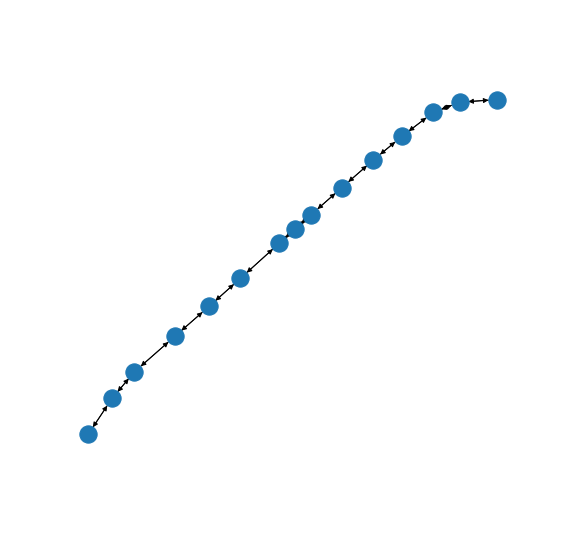

In [3]:
FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2],
        [node_2, node_3],
        [node_3, node_4],
        [node_4, node_5],
        [node_5, node_6],
        [node_6, node_7],
        [node_7, node_8],
        [node_8, node_9],
        [node_9, node_10],
        [node_10, node_11],
        [node_11, node_12],
        [node_12, node_13],
        [node_13, node_14],
        [node_14, node_15],
        [node_15, node_14],
        [node_14, node_13],
        [node_13, node_12],
        [node_12, node_11],
        [node_11, node_10],
        [node_10, node_9],
        [node_9, node_8],
        [node_8, node_7],
        [node_7, node_6],
        [node_6, node_5],
        [node_5, node_4],
        [node_4, node_3],
        [node_3, node_2],
        [node_2, node_1]]

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(FG, positions,ax=ax)
plt.show()

In [4]:
# Start simpy environment (at a given date and time)
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

In [5]:
Vessel = type('Vessel', 
              (corelock.Identifiable, corelock.Movable, corelock.HasContainer, corelock.HasResource, corelock.Routeable, corelock.VesselProperties), {})
start_point = 'Node 15' 
end_point = 'Node 1'  
data_vessel_one = {"env": env,
                   "name": "Vessel",
                   "route": nx.dijkstra_path(FG, start_point, end_point, weight='length'),
                   "geometry": FG.nodes[start_point]['geometry'],
                   "capacity": 1_000,
                   "v": 2,
                   "vessel_type": 'CEMT - Va',
                   "width": 11.40,
                   "height_empty": 7.10, 
                   "height_full": 5.40,
                   "draught_empty": 1.8,
                   "draught_full": 3.5,
                   "length": 135.0}

data_vessel_two = {"env": env,
                   "name": "Vessel",
                   "route": nx.dijkstra_path(FG, end_point, start_point, weight='length'),
                   "geometry": FG.nodes[end_point]['geometry'],
                   "capacity": 1_000,
                   "v": 2,
                   "vessel_type": 'CEMT - Va',
                   "width": 11.40,
                   "height_empty": 7.10, 
                   "height_full": 5.40,
                   "draught_empty": 1.8,
                   "draught_full": 3.5,
                   "length": 135.0}

In [6]:
env.FG = FG
vessels = []
for i in range(3):
    vessel = Vessel(**data_vessel_one)
    vessels.append(vessel)
    
    vessel = Vessel(**data_vessel_two)
    vessels.append(vessel)

In [7]:
waiting_area_1 = corelock.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = 'Volkeraksluizen_1', node = "Node 4")

lineup_area_1 = corelock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = 'Volkeraksluizen_1', node = "Node 6")

lock_1 = corelock.IsLock(env = env, nr_resources = 2, priority = True, name = 'Volkeraksluizen_1',            
                         node_1 = "Node 7", node_2 = "Node 8", node_3 = "Node 9",
                         lock_length = 300, lock_width = 24, lock_depth = 4.5, 
                         doors_open = 10 * 60, doors_close = 10 * 60, operating_time = 25 * 60)
                                      
waiting_area_2 = corelock.IsLockWaitingArea(env = env, nr_resources = 1, priority = True, 
                                            name = "Volkeraksluizen_1", node = "Node 12")

lineup_area_2 = corelock.IsLockLineUpArea(env = env, nr_resources = 1, priority = True, 
                                          name = "Volkeraksluizen_1", node = "Node 10")

In [8]:
#For testing, all locks have the water level at the right side
lock_1.water_level = "Node 7"
FG.nodes["Node 8"]["Lock"] = [lock_1]
FG.nodes["Node 8"]["Lock"] = [lock_1]

FG.nodes["Node 4"]["Waiting area"] = [waiting_area_1]
FG.nodes["Node 6"]["Line-up area"] = [lineup_area_1]

FG.nodes["Node 12"]["Waiting area"] = [waiting_area_2]
FG.nodes["Node 10"]["Line-up area"] = [lineup_area_2] 

In [9]:
for vessel in vessels:
    vessel.env = env
    env.process(vessel.move())

In [10]:
env.FG = FG
env.run()

In [11]:
df = pd.DataFrame.from_dict(vessels[0].log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node Node 15 to node Node 14 start,2021-04-21 14:34:53.000000,0.000000,POINT (4.385356 51.676018)
1,Sailing from node Node 15 to node Node 14 stop,2021-04-21 14:37:43.956780,0.000000,POINT (4.388136 51.678559)
2,Sailing from node Node 14 to node Node 13 start,2021-04-21 14:37:43.956780,0.000000,POINT (4.388136 51.678559)
3,Sailing from node Node 14 to node Node 13 stop,2021-04-21 14:40:01.189458,0.000000,POINT (4.390724 51.680429)
4,Sailing from node Node 13 to node Node 12 start,2021-04-21 14:40:01.189458,0.000000,POINT (4.390724 51.680429)
5,Sailing from node Node 13 to node Node 12 stop,2021-04-21 14:43:36.068689,0.000000,POINT (4.39544 51.682944)
6,Sailing from node Node 12 to node Node 11 start,2021-04-21 14:43:36.068689,0.000000,POINT (4.39544 51.682944)
7,Sailing from node Node 12 to node Node 11 stop,2021-04-21 14:49:36.659561,0.000000,POINT (4.399403 51.68505)
8,Sailing from node Node 11 to node Node 10 start,2021-04-21 14:49:36.659561,0.000000,POINT (4.399403 51.68505)
9,Sailing from node Node 11 to node Node 10 stop,2021-04-21 14:55:10.631463,0.000000,POINT (4.403041 51.687024)


In [12]:
waiting_to_waiting_area = []
waiting_in_waiting_area = []
waiting_in_lineup_area = []
total_waiting_time = np.zeros(len(vessels)-1)

for v in range(0,len(vessels)-1):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop":
            waiting_to_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in waiting area stop":
            waiting_in_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in line-up area stop":
            waiting_in_lineup_area.append(vessels[v].log["Value"][t]/60)
            
for v in range(0,len(vessels)-1):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop" or vessels[v].log["Message"][t] == "Waiting in waiting area stop" or vessels[v].log["Message"][t] == "Waiting in line-up area stop" or  vessels[v].log["Message"][t] == "Passing lock stop": 
            total_waiting_time[v] += ((vessels[v].log["Value"][t]/60))

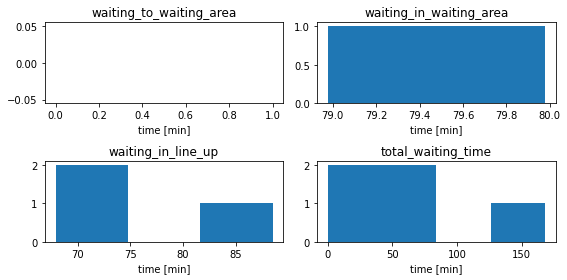

In [13]:
data= [waiting_to_waiting_area,waiting_in_waiting_area,waiting_in_lineup_area,total_waiting_time]
xaxes = 'time [min]'
titles = ['waiting_to_waiting_area','waiting_in_waiting_area','waiting_in_line_up','total_waiting_time'] 

f,a = plt.subplots(2,2,figsize=(8, 4))
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(data[idx], bins = 'auto')
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
plt.tight_layout()

In [14]:
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(orig[0], orig[1], 
                         dest[0], dest[1])[2]
    
    return distance

vessel_path_x = []
vessel_path_t = []

for v in range(0,len(vessels)):
    vessel_path_xt = []
    vessel_path_tt = []
    for t in range(0,len(vessels[v].log["Message"])):
        if vessels[v].route[0] == 'Node 1':   
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = vessels[v].log["Timestamp"][0].timestamp()
            vessel_path_xt.append(calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
        if vessels[v].route[0] == 'Node 15':     
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = vessels[v].log["Timestamp"][0].timestamp()
            vessel_path_xt.append(calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][len(vessels[v].log["Message"])-1].x,vessels[v].log['Geometry'][len(vessels[v].log["Message"])-1].y))-calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
    vessel_path_x.append(vessel_path_xt)
    vessel_path_t.append(vessel_path_tt)

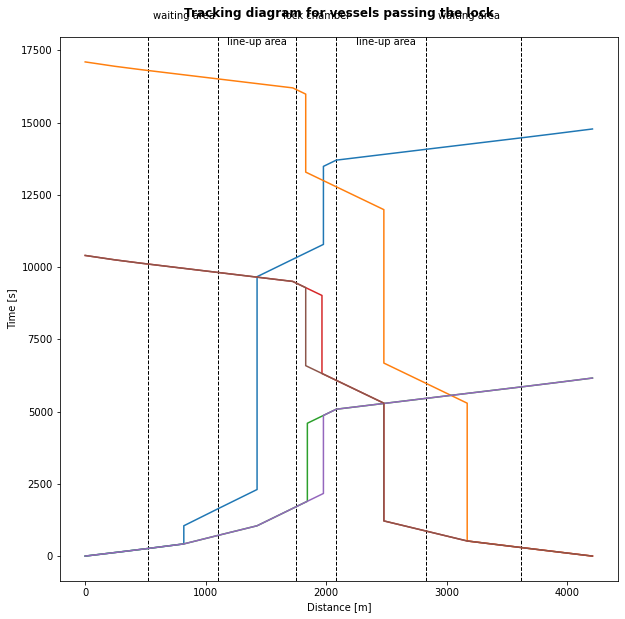

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y,
                                                 FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y,
                                                 FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y,
                                                 FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y,
                                                 FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y,
                                                 FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y,
                                                 FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
for v in reversed(range(0,len(vessels))):
    plt.plot(vessel_path_x[v],vessel_path_t[v])
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),max(max(vessel_path_t))+1500,'lock chamber',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),max(max(vessel_path_t))+600,'line-up area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),max(max(vessel_path_t))+600,'line-up area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),max(max(vessel_path_t))+1500,'waiting area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y, FG.nodes["Node 1"]['geometry'].x,FG.nodes["Node 1"]['geometry'].y)),max(max(vessel_path_t))+1500,'waiting area',horizontalalignment = 'center')
plt.title("Tracking diagram for vessels passing the lock", fontweight='bold', pad = 20)
plt.xlabel("Distance [m]")
plt.ylabel("Time [s]")
plt.show()

In [16]:
df = pd.DataFrame.from_dict(lock_1.log)
df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2021-04-21 15:06:30.728585,Node 7,0
1,Lock doors closing start,2021-04-21 15:11:00.728585,Node 7,0
2,Lock doors closing stop,2021-04-21 15:16:30.728585,Node 7,0
3,Lock chamber converting start,2021-04-21 15:16:30.728585,Node 7,0
4,Lock doors closing stop,2021-04-21 15:21:00.728585,Node 9,0
5,Lock chamber converting start,2021-04-21 15:21:00.728585,Node 9,0
6,Lock chamber converting stop,2021-04-21 15:41:30.728585,Node 9,0
7,Lock doors opening start,2021-04-21 15:41:30.728585,Node 9,0
8,Lock chamber converting stop,2021-04-21 15:46:00.728585,Node 9,0
9,Lock doors opening start,2021-04-21 15:46:00.728585,Node 9,0


In [17]:
lock2 = FG.nodes['Node 8']['Lock'][0]
#lock.resource.request(priority = -1)
#lock.resource.users

In [18]:
lock2.resource.queue[0].priority

IndexError: list index out of range

In [ ]:
a = 1
for q in range(0,a):
    print(q)

In [ ]:
dir(lock2.resource.queue)